<a href="https://colab.research.google.com/github/gopikrishna279/model-training/blob/master/Copy_of_Spinal_Cord_Gray_Matter_Segmentation_Using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spinal Cord Gray Matter Segmentation Using PyTorch
In this notebook we are going to explore a medical imaging open-source library known as [MedicalTorch](https://github.com/perone/medicaltorch), which was built on top of PyTorch. The purpose of this tutorial is to show you the basic functionalities of the tools offered in MedicalTroch, such as pre-processing of images, transformations, and data loaders. With the tools you will be able to explore and preprocess MRI-based datasets that contain images such as shown in the image below. As you progress in the tutorial you shall begin to appreciate the capabilities and possibilities of the medicaltorch library for medical imaging AI applications. 

![alt txt](https://docs.google.com/drawings/d/e/2PACX-1vQmKTAQEz_zoomKa0HchswOUunHQTO3gDoH_VnXfcZdl8N3H0L-aGvM9GqQiiLi-bL0ME4-IoU6cv7g/pub?w=928&h=499)

Image credit: [Perone et al.,2017](https://arxiv.org/pdf/1710.01269.pdf)

## Installing Libraries
Below we will show you how to install the medicaltorch library along with some other libraries.

In [1]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-1.5.0-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision
!pip install medicaltorch
!pip3 install numpy==1.17

     |████████████████████████████████| 20.4MB 1.3MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.4
    Uninstalling numpy-1.18.4:
      Successfully uninstalled numpy-1.18.4


In [0]:
import torch

In [3]:
print(torch.__version__)

1.5.0+cu101


In [4]:
import numpy as np
print(np.__version__)

1.18.4


In [5]:
!pip install torch-geometric \
  torch-sparse==latest+cu101 \
  torch-scatter==latest+cu101 \
  torch-cluster==latest+cu101 \
  -f https://pytorch-geometric.com/whl/torch-1.4.0.html

Looking in links: https://pytorch-geometric.com/whl/torch-1.4.0.html
     |████████████████████████████████| 153kB 13.5MB/s 
     |████████████████████████████████| 15.2MB 207kB/s 
     |████████████████████████████████| 10.6MB 59.3MB/s 
     |████████████████████████████████| 14.5MB 244kB/s 
     |████████████████████████████████| 235kB 39.8MB/s 
     |████████████████████████████████| 2.1MB 56.4MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.5.0-cp36-none-any.whl size=267918 sha256=c71f104a7c81679fcdb23a711a82fb627143f602485401eda995cedbd5f2663a
  Stored in directory: /root/.cache/pip/wheels/ec/51/31/5786f2ac419ee312f22d4d2877da05f20e7f2d430e22917daf
Successfully built torch-geometric


In [6]:
!pip install medicaltorch

In [7]:
!pip3 install torchvision

In [0]:
import medicaltorch

In [0]:
import torchvision

## Mounting Data From Google Drive
I have stored the MRI images on my personal Google Drive, but you may request the data from the [GM SC Challenge](http://niftyweb.cs.ucl.ac.uk/challenge/index.php#citation) website.

In [7]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


## Importing Libraries and Let's Get Started!
Let's import the necessary libraries includinf the utility functions from the `medicaltorch` library.

In [0]:
from collections import defaultdict
import time
import os

import numpy as np

from tqdm import tqdm

from medicaltorch import datasets as mt_datasets
from medicaltorch import models as mt_models
from medicaltorch import transforms as mt_transforms
from medicaltorch import losses as mt_losses
from medicaltorch import metrics as mt_metrics
from medicaltorch import filters as mt_filters

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import autograd, optim
import torch.backends.cudnn as cudnn
import torch.nn as nn

import torchvision.utils as vutils

cudnn.benchmark = True
import matplotlib.pyplot as plt
%matplotlib inline

**bold text**### Data Exploration
Before we do any modeling stuff, let's investigate our data first. Let's look at one sample (MRI image) from the dataset. We will see the preprocessing module `mt_datasets.SegmentationPair2D` which is used to read and format the data in a way that we can better explore it in our environment. See the example below.

In [0]:
ROOT_DIR_GMCHALLENGE = "/gdrive/My Drive/train/"
mri_input_filename = os.path.join(ROOT_DIR_GMCHALLENGE,
                                          'site1-sc01-image.nii.gz')
mri_gt_filename = os.path.join(ROOT_DIR_GMCHALLENGE,
                                       'site1-sc01-mask-r1.nii.gz')

pair = mt_datasets.SegmentationPair2D(mri_input_filename, mri_gt_filename)
slice_pair = pair.get_pair_slice(0)
input_slice = slice_pair["input"]
gt_slice = slice_pair["gt"]

In [11]:
print(input_slice.shape)

(100, 100)


As you can see above, images are 100 X 100 dimensions. We can also view the image in our environment using matplotlib.

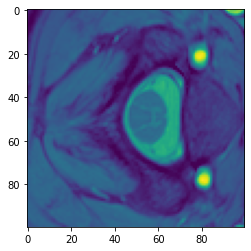

In [12]:
img = input_slice
plt.imshow(img)
plt.show()

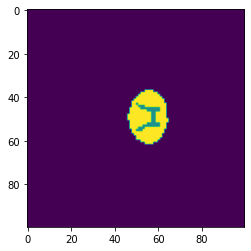

In [13]:
img = gt_slice
plt.imshow(img)
plt.show()

The upper image shows an *in vivo axial-slice* sample while the lower image shows the spinal cord gray matter segmentation. Intuitively, the dataset contains the necessary information to conduct gray matter segmentation using deep learning techniques such as encode/decoder frameworks and deep convolutional neural networks.

## PyTorch Data Loaders
Let's try to use the data loaders offered in medicaltorch to test the transformation functions. PyTorch offers a "transforms" module that helps us to apply any transformations on our data that we may wish, this is by stacking operations a seen below. First we resample the dataset so that all samples are of the same size and then apply a cropping area, followed by a tensor type transformation.

In [0]:
# transformer
composed_transform = transforms.Compose([
            mt_transforms.Resample(0.25, 0.25),
            mt_transforms.CenterCrop2D((200, 200)),
            mt_transforms.ToTensor(),
])

In [0]:
# load data
train_dataset = mt_datasets.SCGMChallenge2DTrain(root_dir=ROOT_DIR_GMCHALLENGE, transform=composed_transform)

In [18]:
print(len(train_dataset))

2204


You can see an example below of how a raw image was converted to a tensor 

1.   List item
2.   List item

format.

In [16]:
# sample of the training dataset
train_dataset[0]

/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


{'gt': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'gt_metadata': <medicaltorch.datasets.SampleMetadata at 0x7f913c942710>,
 'input': tensor([[[ 263.9700,  243.9216,  203.8249,  ..., 1864.4967, 1690.7444,
           1603.8682],
          [ 245.5923,  226.3793,  187.9533,  ..., 1761.1224, 1576.0929,
           1483.5781],
          [ 208.8370,  191.2947,  156.2101,  ..., 1554.3738, 1346.7898,
           1242.9978],
          ...,
          [ 654.0775,  646.1417,  630.2701,  ...,  741.7890,  706.7045,
            689.1621],
          [ 652.4068,  645.3063,  631.1055,  ..., 1040.8435,  958.9795,
            918.0474],
          [ 651.5715,  644.8887,  631.5231,  ..., 1190.3708, 1085.1171,
           1032.4901]]]),
 'input_metadata': <medicaltorch.datasets.SampleMetad

Now that we have the image loaded and transformed into tensors, we provided it to the PyTorch native Dataloader function to do its magic. The DataLoader below basically creates mini-batches and shuffles them.

In [0]:
# PyTorch data loader
dataloader = DataLoader(train_dataset, batch_size=4,
                        shuffle=True, num_workers=4,
                        collate_fn=mt_datasets.mt_collate)
minibatch = next(iter(dataloader))

In [18]:
# check minibatch size
minibatch['input'].size()

torch.Size([4, 1, 200, 200])



```
# This is formatted as code
```

### Visualizing Batches
Below we show you how to visualize batches.

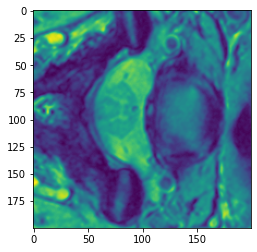

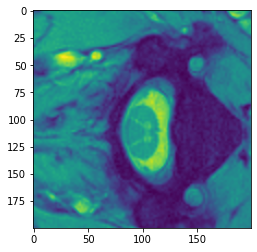

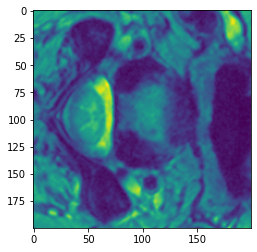

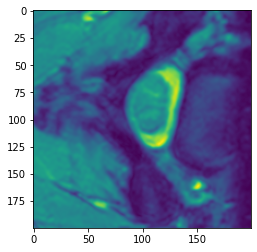

In [19]:
for item in minibatch['input']:
    plt.imshow(item.squeeze(0))
    plt.show()

## Constructing The Segmentation Model
We saw the images above, now we want to build the gray matter segmentation model with the MRI spinal cord images provided above. Let's define a helper function that helps to decide the final predictions of the model.

In [0]:
def threshold_predictions(predictions, thr=0.999):
    thresholded_preds = predictions[:]
    low_values_indices = thresholded_preds < thr
    thresholded_preds[low_values_indices] = 0
    low_values_indices = thresholded_preds >= thr
    thresholded_preds[low_values_indices] = 1
    return thresholded_preds

And here are all the transformations to both the training and validation dataset.

In [0]:
train_transform = transforms.Compose([
        mt_transforms.Resample(0.25, 0.25),
        mt_transforms.CenterCrop2D((200, 200)),
        mt_transforms.ElasticTransform(alpha_range=(28.0, 30.0),
                                       sigma_range=(3.5, 4.0),
                                       p=0.3),
        mt_transforms.RandomAffine(degrees=4.6,
                                   scale=(0.98, 1.02),
                                   translate=(0.03, 0.03)),
        mt_transforms.RandomTensorChannelShift((-0.10, 0.10)),
        mt_transforms.ToTensor(),
        mt_transforms.NormalizeInstance(),
])

val_transform = transforms.Compose([
        mt_transforms.Resample(0.25, 0.25),
        mt_transforms.CenterCrop2D((200, 200)),
        mt_transforms.ToTensor(),
        mt_transforms.NormalizeInstance(),
])

In [0]:
### training dataset with 80/20 split
TRAIN_ROOT_DIR_GMCHALLENGE = "/gdrive/My Drive/train/"

gmdataset_train = mt_datasets.SCGMChallenge2DTrain(root_dir=TRAIN_ROOT_DIR_GMCHALLENGE,
                                                   subj_ids=range(1, 9),
                                                   transform=train_transform,
                                                   slice_filter_fn=mt_filters.SliceFilter())

gmdataset_val = mt_datasets.SCGMChallenge2DTrain(root_dir=TRAIN_ROOT_DIR_GMCHALLENGE,
                                                 subj_ids=range(9, 11),
                                                 transform=val_transform)

In [23]:
print(len(gmdataset_train), len(gmdataset_val))

1423 444


In [24]:
len(gmdataset_train)/16, len(gmdataset_val)/16

(88.9375, 27.75)

In [0]:
train_loader = DataLoader(gmdataset_train, batch_size=16,
                          shuffle=True, pin_memory=True,
                          collate_fn=mt_datasets.mt_collate,
                          num_workers=1)

val_loader = DataLoader(gmdataset_train, batch_size=16,
                        shuffle=True, pin_memory=True,
                        collate_fn=mt_datasets.mt_collate,
                        num_workers=1)

### Model and Parameters
Below we declare our model and parameters. Note that we are using GPU in this notebook. Also note that the model used below refers to the U-net convolutional-based architecture proposed by [Ronneberger et al., 2015](https://arxiv.org/abs/1505.04597), which essentially aggregates semantic information to perform the segmentation. See a figure of the U-net framework below. You can also refer to the medicaltorch [API documentation](https://medicaltorch.readthedocs.io/en/stable/modules.html#module-medicaltorch.models) for more available state-of-the-art implementations. 

![alt txt](https://docs.google.com/drawings/d/e/2PACX-1vT2miqwBsJpm9vX2lH7GRJaMWw3ym9Ld3MNY-10rpKIQJoXvfsRbIu1OpndIn4BJqYUtpq3wZcwmS9v/pub?w=921&h=624)

Image Credit: [Ronneberger et al., 2015](https://arxiv.org/abs/1505.04597)

In [0]:
model = mt_models.Unet(drop_rate=0.4, bn_momentum=0.1)
model.cuda()
num_epochs = 1
initial_lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=initial_lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

Some helper functions to produce the desired metrics for the model such as accuracy.

In [0]:
def numeric_score(prediction, groundtruth):
    FP = np.float(np.sum((prediction == 1) & (groundtruth == 0)))
    FN = np.float(np.sum((prediction == 0) & (groundtruth == 1)))
    TP = np.float(np.sum((prediction == 1) & (groundtruth == 1)))
    TN = np.float(np.sum((prediction == 0) & (groundtruth == 0)))
    return FP, FN, TP, TN 
  
def accuracy(prediction, groundtruth):
    FP, FN, TP, TN = numeric_score(prediction, groundtruth)
    N = FP + FN + TP + TN
    accuracy = np.divide(TP + TN, N)
    return accuracy * 100.0

### Training 
Now we finally train the model for spinal cord gray matter segmentation. We report the training and testing accuracy below and train for 10 epochs only. 

In [28]:
for epoch in tqdm(range(1, num_epochs+1)):
    start_time = time.time()


    lr = scheduler.get_lr()[0]

    model.train()
    train_loss_total = 0.0
    num_steps = 0
    
    ### Training
    for i, batch in enumerate(train_loader):
        input_samples, gt_samples = batch["input"], batch["gt"]

        var_input = input_samples.cuda()
        var_gt = gt_samples.cuda(async=True)

        preds = model(var_input)

        loss = mt_losses.dice_loss(preds, var_gt)
        train_loss_total += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        num_steps += 1

        if epoch % 5 == 0:
            grid_img = vutils.make_grid(input_samples,
                                        normalize=True,
                                        scale_each=True)
            

            grid_img = vutils.make_grid(preds.data.cpu(),
                                        normalize=True,
                                        scale_each=True)
            

            grid_img = vutils.make_grid(gt_samples,
                                        normalize=True,
                                        scale_each=True)
   
    
    train_loss_total_avg = train_loss_total / num_steps
    model.eval()
    val_loss_total = 0.0
    num_steps = 0
    train_acc  = accuracy(preds.cpu().detach().numpy(), 
                          var_gt.cpu().detach().numpy())
    
    metric_fns = [mt_metrics.dice_score,
                  mt_metrics.hausdorff_score,
                  mt_metrics.precision_score,
                  mt_metrics.recall_score,
                  mt_metrics.specificity_score,
                  mt_metrics.intersection_over_union,
                  mt_metrics.accuracy_score]

    metric_mgr = mt_metrics.MetricManager(metric_fns)
    ### Validating
    for i, batch in enumerate(val_loader):
        #print(i)
        input_samples, gt_samples = batch["input"], batch["gt"]
        with torch.no_grad():
           var_input = input_samples.cuda()
           var_gt = gt_samples.cuda(async=True)

           
           preds = model(var_input)
           loss = mt_losses.dice_loss(preds, var_gt) 
           val_loss_total += loss.item()
          

        # Metrics computation
        gt_npy = gt_samples.numpy().astype(np.uint8)
        gt_npy = gt_npy.squeeze(axis=1)

        preds = preds.data.cpu().numpy()
        preds = threshold_predictions(preds)
        preds = preds.astype(np.uint8)
        preds = preds.squeeze(axis=1)

        metric_mgr(preds, gt_npy)

        num_steps += 1
        
    metrics_dict = metric_mgr.get_results()
    metric_mgr.reset()
    val_loss_total_avg = val_loss_total / num_steps
    torch.save(model, "/gdrive/My Drive/tensor.pt")
    print('\nTrain loss: {:.4f}, Training Accuracy: {:.4f} '.format(train_loss_total_avg, train_acc))
    print('Val Loss: {:.4f}, Validation Accuracy: {:.4f} '.format(val_loss_total_avg, metrics_dict["accuracy_score"]))

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:484: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of cuda is deprecated:
	cuda(torch.device device, bool async, *, torch.memory_format memory_format)
Consider using one of the following signatures instead:
	cuda(torch.device device, bool non_blocking, *, torch.memory_format memory_format)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: 


Train loss: -0.3442, Training Accuracy: 69.0907 
Val Loss: -0.4916, Validation Accuracy: 93.9024 


## Final Words
In summary, you learned how to process MRI image scans using a neat and powerful tool known as medicaltorch. In addition, you learned about how to preprocess, prepare and load the data using medicaltorch and PyTorch's build-in DataLoader module. Finally, you trained a model based on convolutional neural networks to conduct spinal cord gray matter segmentation. Feel free to explore more of the utility function provided in the medicaltorch API and explore different types of datasets. Until next time!